## 1. Set up the Notebook and connect to the dataset

In [33]:
import pandas as pd
original_collections_df = pd.read_excel('Collections_Provenance.xlsx')

In [34]:
# Selecting collectinons whose origin is China

# Select items originated from China
china_collections = original_collections_df[original_collections_df['Geography'].str.contains('China', case=False, na=False)]

# Create a new file
china_collections.to_excel('China_Collections.xlsx', index=False)

## 2. Clean the dataset

#### In the cleaning phase of this project, I focused on standardizing entries related to provinces and dynasties. 

#### Initially, I observed inconsistencies in the “Geography” column, where entries varied widely, with some specifying provinces, others cities, or even specific locations. Using Python, I implemented scripts to categorize these irregular entries into consistent province categories. Additionally, I tried to identify municipalities directly under the central government. Following this, I manually cleaned some remaining irregular entries to ensure accuracy.

#### For the “Dynasty” section, I relied on manual classification, following criteria and methods detailed in the thesis. Each artifact was assigned to its corresponding dynasty based on established historical frameworks. 

#### The result of this comprehensive cleaning process was the creation of a new dataset.

In [4]:
# Provinces


china_collections_df = pd.read_excel('China_Collections.xlsx')

# 将 "Geography" 列的内容拆分成多个列
geography_split = china_collections_df['Geography'].str.split(',', expand=True)

# 初始化新的列
china_collections_df['Location'] = ''
china_collections_df['Province'] = ''
china_collections_df['Country'] = ''

# 处理情况1：含三个元素
mask = (geography_split[0].str.strip() != 'China') & (geography_split[1].str.strip() != 'China')
china_collections_df.loc[mask, 'Location'] = geography_split[0].str.strip()
china_collections_df.loc[mask, 'Province'] = geography_split[1].str.strip()
china_collections_df.loc[mask, 'Country'] = geography_split[2].str.strip()

# 处理情况2：只含China
mask = (geography_split[0].str.strip() == 'China')
china_collections_df.loc[mask, 'Country'] = 'China'

# 处理情况3：只含某个地点
mask = (geography_split[1].str.strip() == 'China') & (geography_split[0].str.strip() != 'China')
province_mask = geography_split[0].str.contains('province', case=False)
location_mask = ~province_mask
china_collections_df.loc[mask & location_mask, 'Location'] = geography_split[0].str.strip()
china_collections_df.loc[mask & location_mask, 'Country'] = 'China'  # 保留 "China"

# 处理情况4：省份, China
mask = (geography_split[0].str.strip() != 'China') & (geography_split[1].str.strip() == 'China') & (geography_split[0].str.contains('province', case=False))
china_collections_df.loc[mask, 'Province'] = geography_split[0].str.extract(r'([^,]+) province', expand=False)
china_collections_df.loc[mask, 'Country'] = geography_split[1].str.strip()

# 写入新文件
china_collections_df.to_excel('China_Collections_Processed.xlsx', index=False)

In [5]:
# Check whether there's any municipality in the location column 

# Selected qualified rows
filtered_rows = china_collections_df[china_collections_df['Province'].isin(['Beijing', 'Chongqing', 'Tianjin', 'Shanghai'])]

# If they do exist, print out their EDAN ID; if not, show the sentence
if not filtered_rows.empty:
    print(filtered_rows['EDAN ID'])
else:
    print("There is no such row.")

There is no such row.


In [6]:

import re
import numpy as np

china_collections_df = pd.read_excel('China_Collections_Processed.xlsx')

# 将包含 "or" 的行的 "Province" 和 "Specific Location" 列设置为空
china_collections_df.loc[china_collections_df['Geography'].str.contains('or'), ['Province', 'Specific Location']] = ''

# 将 "province" 统一为 "Province"
china_collections_df['Province'] = china_collections_df['Province'].str.replace(r'\bprovince\b', 'Province', regex=True)

# 使用正则表达式删除指定的文本
china_collections_df['Province'] = china_collections_df['Province'].str.replace(r'\bpurportedly found at\b|\bpurportedly from\b', '', regex=True)


# 提取出剩下的部分
china_collections_df['Province'] = china_collections_df['Province'].astype(str).apply(lambda x: re.sub(r'\s+', ' ', x.strip()))

# "Kashgar Province" was counted as "Xinjiang Province"
china_collections_df['Province'] = china_collections_df['Province'].str.replace('Kashgar Province', 'Xinjiang Province')

# 替换空字符串为 NaN
china_collections_df['Province'] = china_collections_df['Province'].replace('', np.nan)

# 填充 None 值为 NaN
china_collections_df['Province'] = china_collections_df['Province'].fillna(np.nan)


china_collections_df.to_excel('China_Collections_Processed.xlsx', index=False)

/var/folders/2q/4pt3l1310hsdw3s3474_y5p80000gn/T/ipykernel_4331/4279879001.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  china_collections_df.loc[china_collections_df['Geography'].str.contains('or'), ['Province', 'Specific Location']] = ''


In [7]:
# Further Check 

# 定义一个函数来处理字符串
def format_province(province):
    if pd.notna(province) and province.strip() != '':  # 检查非空值和非空字符串
        return province.strip().title() + ' Province'  # 首字母大写并加上 ' Province'
    return province  # 返回原始值（NaN 或空字符串）

# 使用 apply 方法应用上述函数到 'Province' 列
china_collections_df['Province'] = china_collections_df['Province'].apply(format_province)

# 打印处理后的 DataFrame
# print("\nAfter processing:")
# print(china_collections_df)

# 保存更新后的 DataFrame
china_collections_df.to_excel('China_Collections_Processed.xlsx', index=False)

#### For artifacts with specific location information but no province, I manually standardized them to their respective provinces. And then a new column was manually created to assign each artifact to its corresponding dynasty.

In [8]:
china_collections_df = pd.read_excel('Final_Chinese_Collections.xlsx')

## 3. Overview of Chinese Artifacts 

### 3.1 Analysis of Artifact Volume

#### Caculate number of artifcts acquired in each year

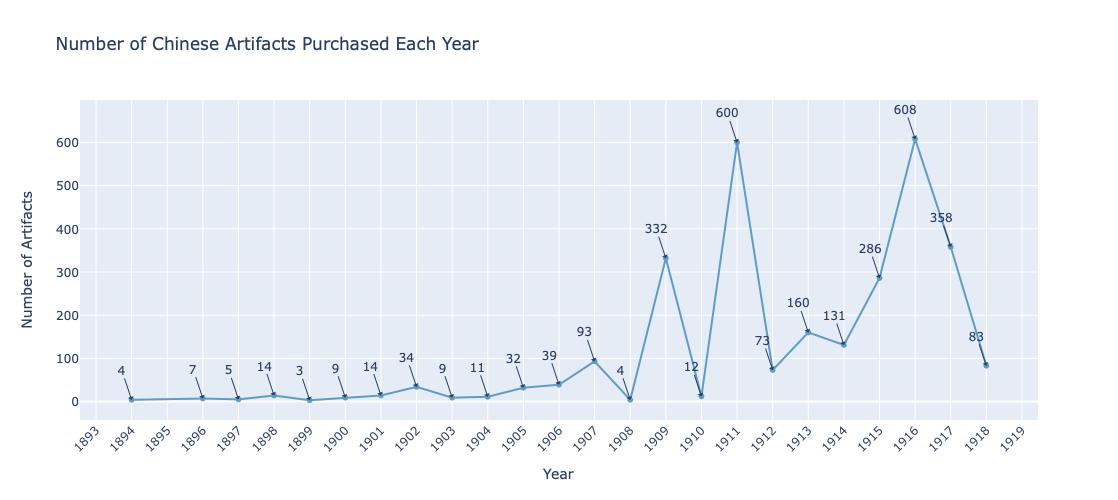

In [9]:

import plotly.graph_objects as go

# 获取购买次数
purchase_counts = china_collections_df['Purchase_Year'].value_counts().sort_index()



# 创建折线图
fig = go.Figure()

# 添加折线
fig.add_trace(go.Scatter(x=purchase_counts.index, y=purchase_counts.values,
                    mode='lines+markers',
                    name='Number of Artifacts Purchased',
                    line=dict(color='#619AC3')))  # 设置折线颜色为 #012a4a #619AC3 ##0582ca 原色

# 在每个端点显示具体的数字
for year, count in zip(purchase_counts.index, purchase_counts.values):
    fig.add_annotation(x=year, y=count,
                       text=str(count),
                       showarrow=True,
                       arrowhead=1)

# 设置图表布局
fig.update_layout(title='Number of Chinese Artifacts Purchased Each Year',
                   xaxis_title='Year',
                   yaxis_title='Number of Artifacts',
                   xaxis=dict(tickmode='linear'),
                   yaxis=dict(type='linear'),
                   xaxis_tickangle=-45,
                   height=500)  # 设置图表高度为 500 像素

# 显示图表
fig.show()

#### Compare all numbers and Chinese ones

In [10]:

# China

# 获取购买次数
purchase_counts = china_collections_df['Purchase_Year'].value_counts().sort_index()

# 将数据转换为字典
China_data = {
    'Date': purchase_counts.index.tolist(),  # 将年份索引转换为列表
    'Value1': purchase_counts.values.tolist()  # 将购买数量转换为列表
}

# 打印字典
print(China_data)

{'Date': [1894.0, 1896.0, 1897.0, 1898.0, 1899.0, 1900.0, 1901.0, 1902.0, 1903.0, 1904.0, 1905.0, 1906.0, 1907.0, 1908.0, 1909.0, 1910.0, 1911.0, 1912.0, 1913.0, 1914.0, 1915.0, 1916.0, 1917.0, 1918.0], 'Value1': [4, 7, 5, 14, 3, 9, 14, 34, 9, 11, 32, 39, 93, 4, 332, 12, 600, 73, 160, 131, 286, 608, 358, 83]}


In [11]:
# All Collections

original_collections_df = pd.read_excel('Collections_Provenance.xlsx')
# 获取购买次数
purchase_counts = original_collections_df['Purchase_Year'].value_counts().sort_index()

# 将数据转换为字典
World_data = {
    'Date': purchase_counts.index.tolist(),  # 将年份索引转换为列表
    'Value1': purchase_counts.values.tolist()  # 将购买数量转换为列表
}

# 打印字典
print(World_data)

{'Date': [1883.0, 1887.0, 1888.0, 1889.0, 1890.0, 1891.0, 1892.0, 1893.0, 1894.0, 1895.0, 1896.0, 1897.0, 1898.0, 1899.0, 1900.0, 1901.0, 1902.0, 1903.0, 1904.0, 1905.0, 1906.0, 1907.0, 1908.0, 1909.0, 1910.0, 1911.0, 1912.0, 1913.0, 1914.0, 1915.0, 1916.0, 1917.0, 1918.0, 1919.0], 'Value1': [1, 27, 38, 29, 10, 15, 16, 96, 50, 7, 102, 88, 267, 111, 80, 185, 429, 227, 449, 298, 191, 677, 305, 1793, 45, 715, 96, 181, 149, 333, 728, 447, 102, 1]}


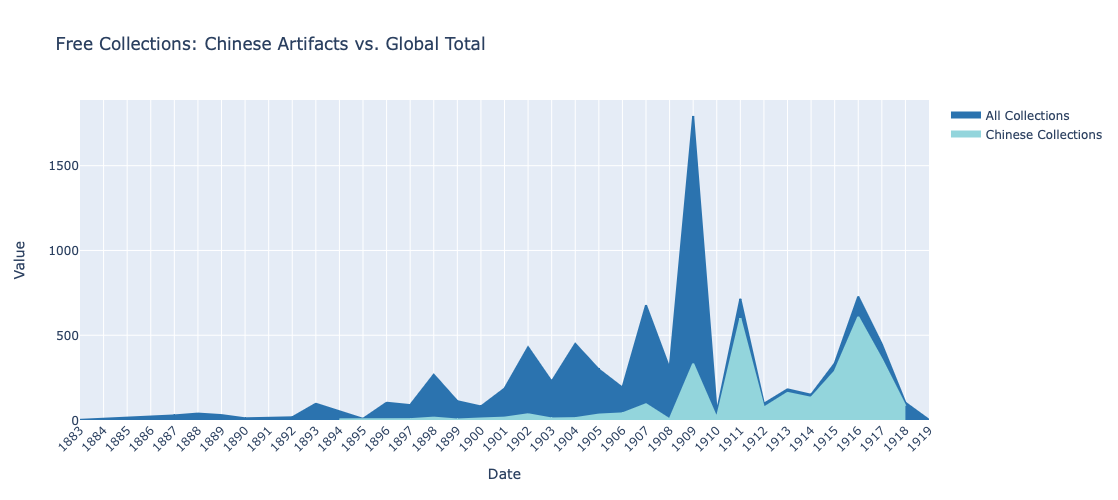

In [12]:
import plotly.graph_objects as go

# 创建 Plotly 图表对象
fig = go.Figure()

# 添加世界的数据面积图
fig.add_trace(go.Scatter(
    x=World_data['Date'], y=World_data['Value1'],
    mode='lines',
    name='All Collections',
    line=dict(color='#2B73AF', width=2),
    fill='tozeroy',
    fillcolor='rgba(43, 115, 175, 1)'  # 设置填充颜色和透明度
    # 添加填充区域
))

# 添加中国的数据面积图
fig.add_trace(go.Scatter(
    x=China_data['Date'], y=China_data['Value1'],
    mode='lines',
    name='Chinese Collections',
    line=dict(color='#93D5DC', width=2),
    fill='tozeroy',
    fillcolor='rgba(147, 213, 220, 1)'# 添加填充区域
))

# 设置图表布局
fig.update_layout(
    title='Free Collections: Chinese Artifacts vs. Global Total',
    xaxis_title='Date',
    yaxis_title='Value',
    xaxis=dict(tickmode='linear'),
    yaxis=dict(type='linear'),
    xaxis_tickangle=-45,
    height=500
)

# 显示图表
fig.show()

### 3.2 Analysis of Artifact Types

In [13]:
# 计算 'Type' 列的唯一值数量
unique_types_count = china_collections_df['Type'].nunique()

# 打印唯一值的数量
print(unique_types_count)

20


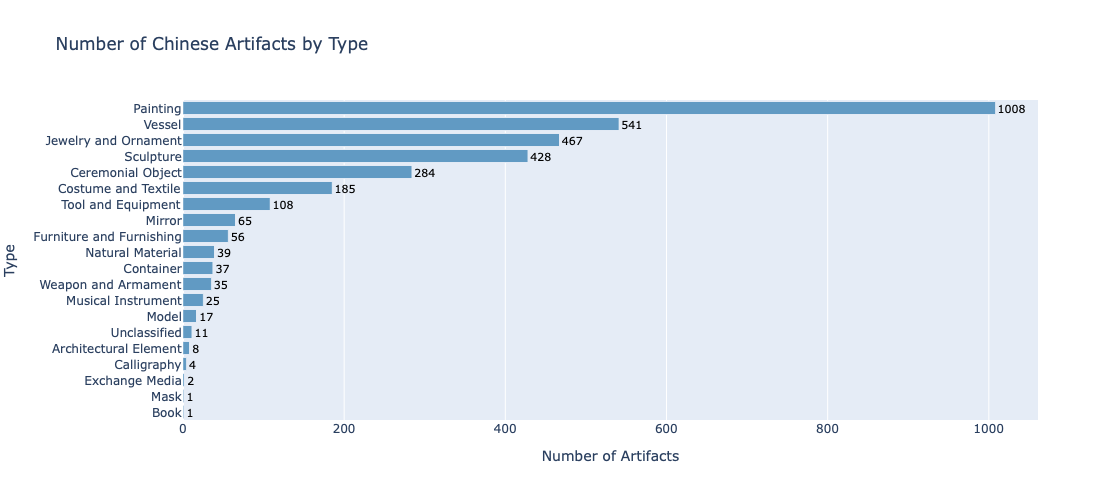

In [14]:
import plotly.graph_objects as go


# 计算每种类型的数量并进行排序
type_counts = china_collections_df['Type'].value_counts().sort_values(ascending=False)


# 创建横向条形图
fig = go.Figure(go.Bar(
    y=type_counts.index,
    x=type_counts.values,
    orientation='h',
    marker=dict(color='#619AC3'),  # 设置条形的颜色为深蓝色
    text=type_counts.values,
    textposition='outside',
    textfont=dict(color='black')
))

# 设置图表布局
fig.update_layout(
    title='Number of Chinese Artifacts by Type',
    xaxis_title='Number of Artifacts',
    yaxis_title='Type',
    yaxis=dict(categoryorder='total ascending'),
    height=500  # 设置图表高度
)

# 显示图表
fig.show()

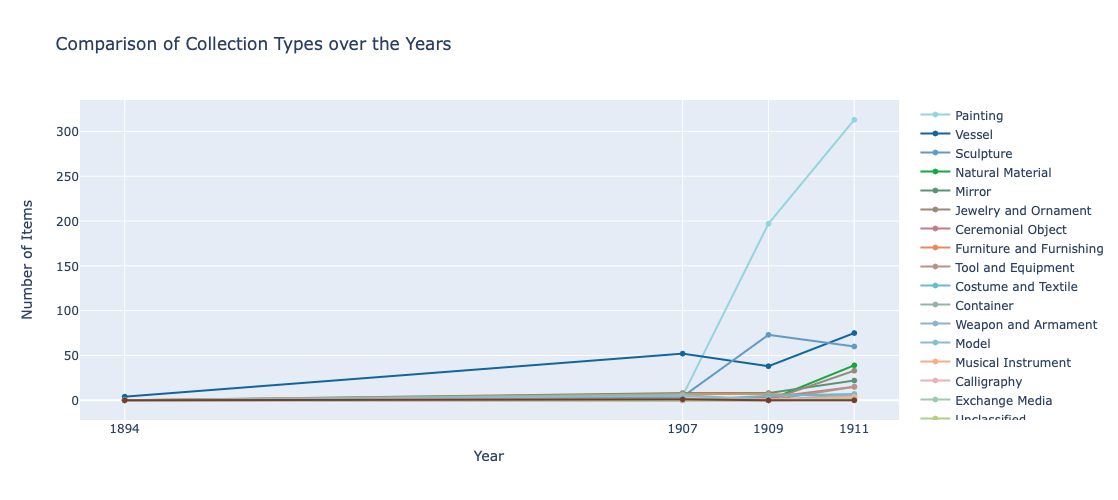

In [15]:
#import pandas as pd
#import plotly.graph_objects as go
#from matplotlib.colors import LinearSegmentedColormap
#import numpy as np

# 合并颜色列表
all_colors = ["#93D5DC","#11659A","#619AC3","#16A840","#579572","#9A8878","#C27C88",
    "#EA8958","#B89485","#63BDD0","#92B4A5","#8FB2C9","#8ABCD1","#F6AD8F","#E3B4B8","#9ECCAB","#B2CF87","#773D31"]


# 需要的年份
years = [1894, 1907, 1909, 1911]

# 过滤指定年份的数据
data_years = china_collections_df[china_collections_df['Purchase_Year'].isin(years)]

# 计算每年每种类型的数量
type_counts_by_year = data_years.groupby(['Purchase_Year', 'Type']).size().unstack(fill_value=0)

# 计算每种类型的总和，并按总和从大到小排序
total_counts = type_counts_by_year.sum(axis=0).sort_values(ascending=False)
sorted_types = total_counts.index

# 按排序后的类型顺序重新排列数据框
type_counts_by_year = type_counts_by_year[sorted_types]

# 创建折线图
fig = go.Figure()

# 添加每种类型的折线图
for i, type_ in enumerate(sorted_types):
    fig.add_trace(go.Scatter(
        x=type_counts_by_year.index,
        y=type_counts_by_year[type_],
        mode='lines+markers',
        name=type_,
        line=dict(color=all_colors[i % len(all_colors)])
    ))

# 更新图表布局
fig.update_layout(
    title='Comparison of Collection Types over the Years',
    xaxis_title='Year',
    yaxis_title='Number of Items',
    xaxis=dict(tickvals=years),  # 只显示特定的年份
    height=500
)

# 显示图表
fig.show()


#### Intervals between dynasties were adjusted for clarity. Deatils are descirbed in thesis.

In [17]:
# 打印 'Dynasty' 列的原始值，方便查看更改前的内容（可选）
print("Before update:")
print(china_collections_df['Dynasty'].unique())

# 将 'Dynasty' 列中包含 'Neolithic Cultures of China' 的所有值归为 'Neolithic Cultures of China'
china_collections_df.loc[china_collections_df['Dynasty'].str.contains('Neolithic Cultures of China', na=False), 'Dynasty'] = 'Neolithic Cultures of China'

# 打印 'Dynasty' 列的更新后的值，查看更改后的内容（可选）
print("\nAfter update:")
print(china_collections_df['Dynasty'].unique())

Before update:
['Qing Dynasty' nan 'Song Dynasty' 'Tang Dynasty' 'Ming Dynasty'
 'Zhou Dynasty' 'Han Dynasty' 'Yuan Dynasty' 'Xia Dynasty'
 'Northern and Southern Dynasties' 'Sui Dynasty'
 'Neolithic Cultures of China (Yueshi Culture)'
 'Neolithic Cultures of China ' 'Liao Dynasty'
 'Five Dynasties and Ten Kingdoms' 'Shang Dynasty'
 'Neolithic Cultures of China (Liangzhu Culture)'
 'Neolithic Cultures of China (Longshan culture)'
 'Neolithic Cultures of China (Erligang Culture)'
 'Neolithic Cultures of China (Dawenkou Culture)'
 'Neolithic Cultures of China (Shimao Culture)'
 'Neolithic Cultures of China (Majiayao Culture)'
 'Neolithic Cultures of China (Baodun Culture)'
 'The Three Kingdoms Period'
 'The Spring and Autumn and Warring States Periods']

After update:
['Qing Dynasty' nan 'Song Dynasty' 'Tang Dynasty' 'Ming Dynasty'
 'Zhou Dynasty' 'Han Dynasty' 'Yuan Dynasty' 'Xia Dynasty'
 'Northern and Southern Dynasties' 'Sui Dynasty'
 'Neolithic Cultures of China' 'Liao Dynasty'
 'Fi

#### Given that paintings comprise the largest portion of the collection, this section focuses on analyzing their distribution across various dynasties and comparing the number of paintings to the overall artifact count.

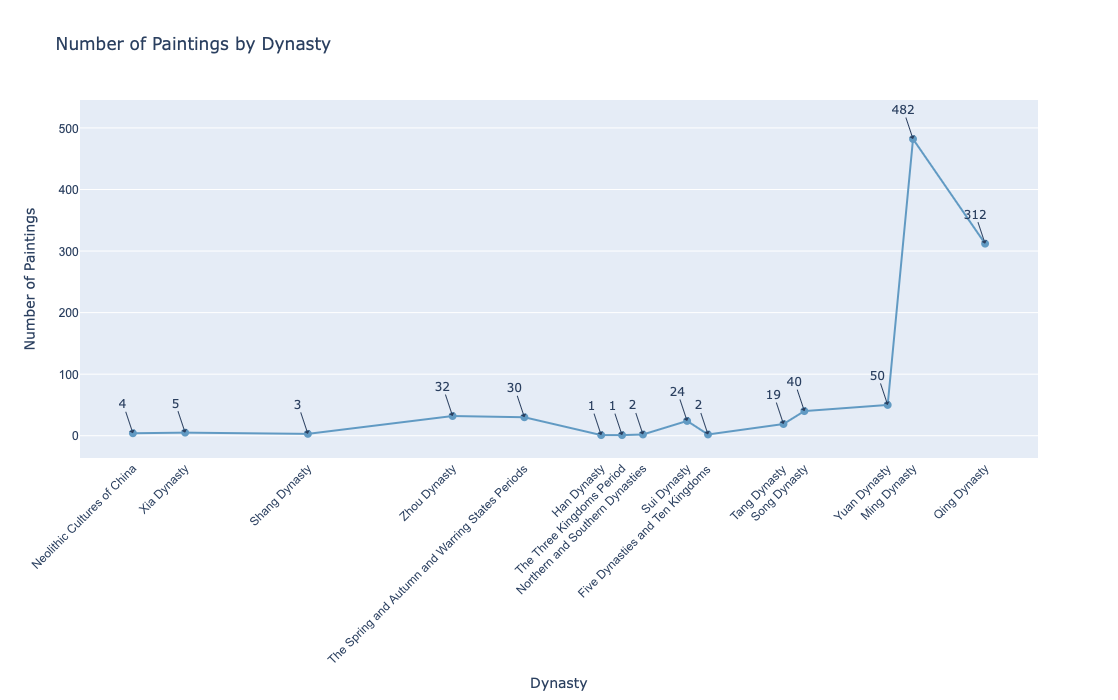

In [16]:


# Define the dynasty names and painting counts
dynasty_data = {
    'Dynasty': [
        'Neolithic Cultures of China', 'Xia Dynasty', 'Shang Dynasty', 'Zhou Dynasty',
        'The Spring and Autumn and Warring States Periods', 'Han Dynasty',
        'The Three Kingdoms Period', 'Northern and Southern Dynasties', 'Sui Dynasty',
        'Five Dynasties and Ten Kingdoms', 'Tang Dynasty',
        'Song Dynasty', 'Yuan Dynasty', 'Ming Dynasty', 'Qing Dynasty'
    ],
}

# Painting counts for each dynasty in order
painting_counts = [4, 5, 3, 32, 30, 1, 1, 2, 24, 2, 19, 40, 50, 482, 312]

# X-axis intervals between dynasties
intervals = [200, 470, 554, 275, 294, 80, 80, 169, 80, 289, 80, 319, 97, 276, 267]

# Calculate cumulative x positions for each dynasty
x_positions = [0]  # Starting position for the first dynasty

# Calculate cumulative positions based on the intervals
for interval in intervals:
    x_positions.append(x_positions[-1] + interval)

# Create the figure
fig = go.Figure()

# Add a scatter plot for the dynasties
fig.add_trace(go.Scatter(
    x=x_positions,
    y=painting_counts,
    mode='lines+markers',
    name='Number of Paintings',
    line=dict(color='#619AC3', width=2),  # Line color and width
    marker=dict(size=8),  # Reduce the marker size
    showlegend=False
))

# Add annotations to display the painting counts
for x_pos, count in zip(x_positions, painting_counts):
    fig.add_annotation(x=x_pos, y=count,
                       text=str(int(count)),  # Display count as text
                       showarrow=True,
                       arrowhead=1,
                       xanchor='center')

# Set up the layout
fig.update_layout(
    title='Number of Paintings by Dynasty',
    xaxis_title='Dynasty',
    yaxis_title='Number of Paintings',
    xaxis=dict(
        tickmode='array',
        tickvals=x_positions,
        ticktext=dynasty_data['Dynasty'],
        tickangle=-45,  # Rotate x-axis labels
        tickfont_family='Arial',
        showgrid=False,
        zeroline=False
    ),
    yaxis=dict(
        tickfont_family='Arial',
        showgrid=True,
        zeroline=False
    ),
    height=700,
    width=1100,
)

# Display the chart
fig.show()


In [18]:
# Define the order of dynasties
dynasty_order = [
    'Neolithic Cultures of China', 'Xia Dynasty', 'Shang Dynasty', 'Zhou Dynasty',
    'The Spring and Autumn and Warring States Periods', 'Han Dynasty',
    'The Three Kingdoms Period', 'Northern and Southern Dynasties', 'Sui Dynasty',
    'Five Dynasties and Ten Kingdoms', 'Tang Dynasty',
    'Song Dynasty', 'Yuan Dynasty', 'Ming Dynasty', 'Qing Dynasty'
]
# Calculate the counts
painting_df = china_collections_df[china_collections_df['Type'] == 'Painting']
painting_counts = painting_df['Dynasty'].value_counts().reindex(dynasty_order).fillna(0).tolist()
total_counts = china_collections_df['Dynasty'].value_counts().reindex(dynasty_order).fillna(0).tolist()
print(painting_counts)

[4, 5, 3, 32, 1, 30, 1, 24, 2, 2, 19, 40, 50, 482, 312]


In [19]:
print(total_counts)

[163, 19, 41, 197, 4, 253, 26, 86, 11, 7, 216, 240, 127, 732, 1015]


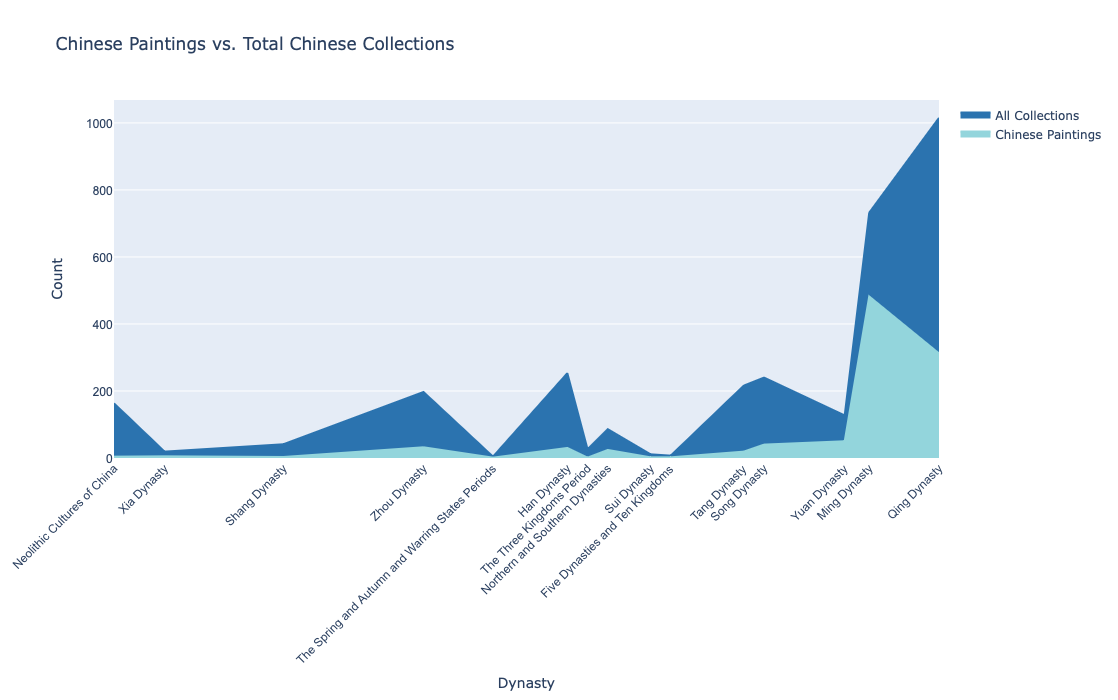

In [20]:
#import pandas as pd
#import plotly.graph_objects as go

# 定义朝代顺序
# dynasty_order = [
    'Neolithic Cultures of China', 'Xia Dynasty', 'Shang Dynasty', 'Zhou Dynasty',
    'The Spring and Autumn and Warring States Periods', 'Han Dynasty',
    'The Three Kingdoms Period', 'Northern and Southern Dynasties', 'Sui Dynasty',
    'Five Dynasties and Ten Kingdoms', 'Tang Dynasty',
    'Song Dynasty', 'Yuan Dynasty', 'Ming Dynasty', 'Qing Dynasty'
]

# 计算绘画数量
painting_df = china_collections_df[china_collections_df['Type'] == 'Painting']
painting_counts = painting_df['Dynasty'].value_counts().reindex(dynasty_order).fillna(0).tolist()

# 计算总藏品数量
total_counts = china_collections_df['Dynasty'].value_counts().reindex(dynasty_order).fillna(0).tolist()

# X轴间隔（根据实际需求设置）
intervals = [200, 470, 554, 275, 294, 80, 80, 169, 80, 289, 80, 319, 97, 276, 267]

# 计算每个朝代的累计 x 位置
x_positions = [0]  # 从第一个朝代开始
for interval in intervals:
    x_positions.append(x_positions[-1] + interval)

# 创建图表
fig = go.Figure()

# 添加总藏品的面积图（深色）
fig.add_trace(go.Scatter(
    x=x_positions,
    y=total_counts,
    mode='lines',
    name='All Collections',
    line=dict(color='#2B73AF', width=2),  # 线条颜色
    fill='tozeroy',
    fillcolor='rgba(43, 115, 175, 1)'  # 深蓝色填充
))

# 添加绘画数量的面积图（浅色）
fig.add_trace(go.Scatter(
    x=x_positions,
    y=painting_counts,  # 填充到0（基线）
    mode='lines',
    name='Chinese Paintings',
    line=dict(color='#93D5DC', width=2),  # 线条颜色
    fill='tozeroy',
    fillcolor='rgba(147, 213, 220, 1)'  # 浅青色填充
    
))

# 设置图表布局
fig.update_layout(
    title='Chinese Paintings vs. Total Chinese Collections',
    xaxis_title='Dynasty',
    yaxis_title='Count',
    xaxis=dict(
        tickmode='array',
        tickvals=x_positions,
        ticktext=dynasty_order,
        tickangle=-45,
        showgrid=False,  # 去掉背景网格线
        zeroline=False,  # 去掉背景零线
        tickfont_family='Arial'
    ),
    yaxis=dict(
        showgrid=True,  # 只显示背景横线
        zeroline=False,  # 去掉背景零线
        tickfont_family='Arial'
    ),
    height=700,
    width=1100
)

# 显示图表
fig.show()


### 3.3 Analysis of Suppliers

#### This section primarily illustrates the relationship between suppliers and the categories of items they supplied. 

In [21]:

# 删除 '(C.L. Freer source)'
china_collections_df['Previous custodian or owner'] = china_collections_df['Previous custodian or owner'].str.replace('(C.L. Freer source)', '')

# 处理 NaN 值，将其替换为一个空字符串
china_collections_df['Previous custodian or owner'].fillna('', inplace=True)

# 去除空字符串和 "Charles Lang Freer (1854-1919)"
cleaned_column = [item.strip() for item in china_collections_df['Previous custodian or owner'] if item.strip() and item.strip() != "Charles Lang Freer (1854-1919)"]

# 计算独特的供应商数量
unique_contributors = pd.Series(cleaned_column).nunique()

print(f"There are {unique_contributors} unique suppliers.")


There are 179 unique suppliers.


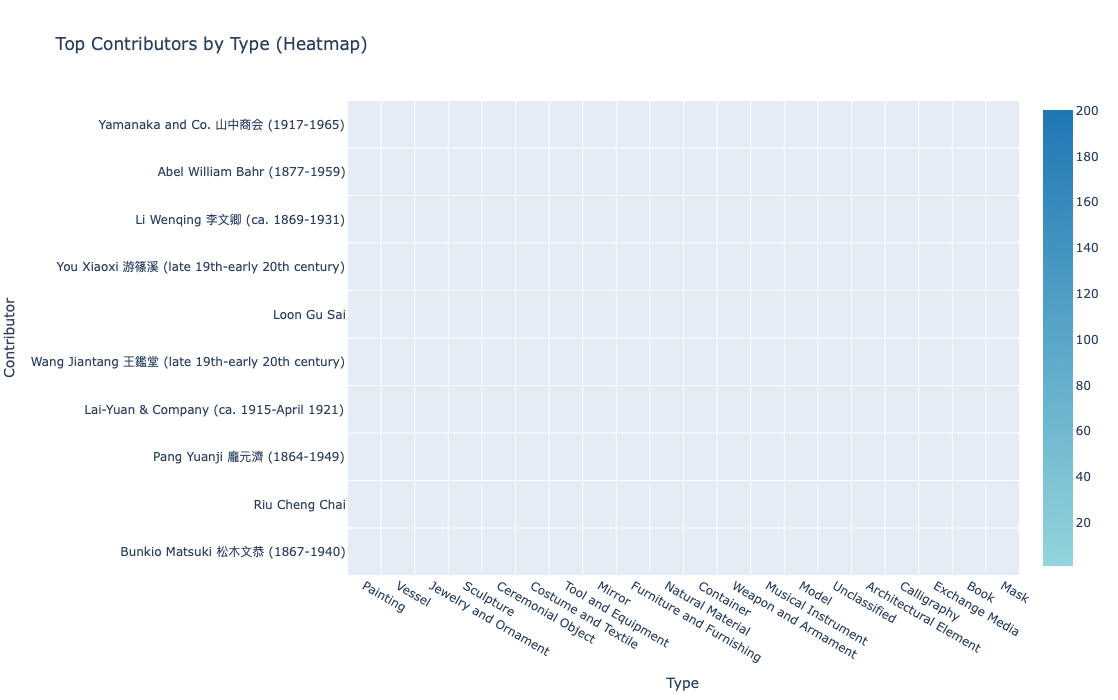

In [22]:
import plotly.io as pio  
import pandas as pd
import plotly.graph_objects as go

# color from light to dark
custom_colors = [[0, '#93D5DC'], [1, '#1f77b4']]



# delete string '(C.L. Freer source)'
china_collections_df['Previous custodian or owner'] = china_collections_df['Previous custodian or owner'].str.replace('(C.L. Freer source)', '')

# 处理 NaN 值，将其替换为一个空字符串
china_collections_df['Previous custodian or owner'].fillna('', inplace=True)

# 定义函数来处理每个单元格
def process_cell(cell):
    return cell.split('\n')  # 按照 '\n' 分割

# 应用函数到每个单元格
split_results = china_collections_df['Previous custodian or owner'].apply(process_cell)

# 将结果转换为 DataFrame
split_df = pd.DataFrame(split_results.tolist())

# 处理 NaN 值，将其替换为一个空字符串
split_df.fillna('', inplace=True)

# 将列合并成一列
merged_column = split_df.values.flatten()

# 去除空字符串和 "Charles Lang Freer (1854-1919)"
merged_column = [item.strip() for item in merged_column if item.strip() and item.strip() != "Charles Lang Freer (1854-1919)"]

# 统计不同贡献者的数量
contributor_counts = pd.Series(merged_column).value_counts()

# 取前十个贡献者，并按数量从少到多排序
top_contributors = contributor_counts.head(10).sort_values(ascending=True)

# 获取唯一的类型
types = china_collections_df['Type'].unique()

# 创建一个空的 DataFrame 来存储每种类型的贡献者数量
type_contributors_df = pd.DataFrame(index=top_contributors.index, columns=types)

# 填充 DataFrame，将每种类型的贡献者数量填入
for type in types:
    type_rows = china_collections_df[china_collections_df['Type'] == type].copy()  # 避免 SettingWithCopyWarning
    type_rows['Previous custodian or owner'].fillna('', inplace=True)
    type_split_results = type_rows['Previous custodian or owner'].apply(process_cell)
    type_split_df = pd.DataFrame(type_split_results.tolist())
    type_split_df.fillna('', inplace=True)
    type_merged_column = type_split_df.values.flatten()
    type_merged_column = [item.strip() for item in type_merged_column if item.strip() and item.strip() != "Charles Lang Freer (1854-1919)"]
    type_contributor_counts = pd.Series(type_merged_column).value_counts()
    type_contributors_df[type] = type_contributor_counts

# 计算每种类型的总数
type_totals = china_collections_df['Type'].value_counts()

# 按总数对类型进行排序
sorted_types = type_totals.index

# 根据排序后的类型重新排列热力图的 x 轴
fig = go.Figure(data=go.Heatmap(
    z=type_contributors_df[sorted_types].values,
    x=sorted_types,
    y=top_contributors.index,
    colorscale=custom_colors,
    hoverongaps=False,
    zmin=0  # 保证颜色从浅色开始
))

# 添加白色网格线
for i in range(len(sorted_types) + 1):
    fig.add_shape(
        type="line",
        x0=i - 0.5, y0=-0.5, x1=i - 0.5, y1=len(top_contributors) - 0.5,
        line=dict(color="white", width=1)
    )
for j in range(len(top_contributors) + 1):
    fig.add_shape(
        type="line",
        x0=-0.5, y0=j - 0.5, x1=len(sorted_types) - 0.5, y1=j - 0.5,
        line=dict(color="white", width=1)
    )

# 设置图表布局，并对齐网格线
fig.update_layout(
    title='Top Contributors by Type (Heatmap)',
    xaxis_title='Type',
    yaxis_title='Contributor',
    height=700,
    width=1100,
    paper_bgcolor='rgba(0, 0, 0, 0)',  # 设置整体背景为透明
    xaxis=dict(
        tickmode='array',
        tickvals=list(range(len(sorted_types))),
        ticktext=sorted_types,
        #tickangle=-35,  # 旋转 X 轴文字
        showgrid=False  # 隐藏默认网格线
    ),
    yaxis=dict(
        tickmode='array',
        tickvals=list(range(len(top_contributors.index))),
        ticktext=top_contributors.index,
        showgrid=False  # 隐藏默认网格线
    )
)


fig.show()



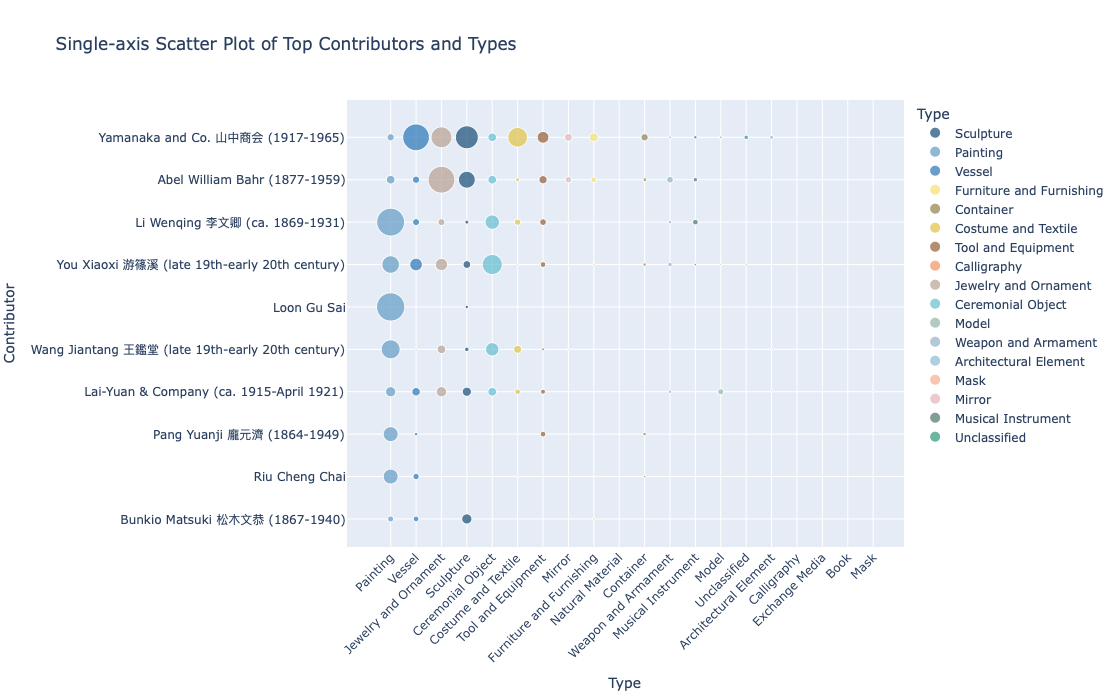

In [24]:
import pandas as pd
import plotly.express as px

# 定义颜色
custom_colors = [
    '#144A74', '#619AC3', '#2775B6', 
    '#F8DF72', '#8E804B', '#DFC243',  
    '#945B33', '#F0945D', '#B7A091',
     '#63BDD0',"#92B4A5", "#8FB2C9",
    "#8ABCD1","#F6AD8F","#E3B4B8",
    "#497568","#2C9678"  
]



# 删除 '(C.L. Freer source)'
china_collections_df['Previous custodian or owner'] = china_collections_df['Previous custodian or owner'].str.replace('(C.L. Freer source)', '')

# 处理 NaN 值，将其替换为一个空字符串
china_collections_df['Previous custodian or owner'].fillna('', inplace=True)

# 定义函数
def process_cell(cell):
    return cell.split('\n')  # 按照 '\n' 分割

# 应用函数到每个单元格
split_results = china_collections_df['Previous custodian or owner'].apply(process_cell)

# 将结果转换为 DataFrame
split_df = pd.DataFrame(split_results.tolist())

# 处理 NaN 值，将其替换为一个空字符串
split_df.fillna('', inplace=True)

# 合并列
merged_column = split_df.values.flatten()

# 去除空字符串和 "Charles Lang Freer (1854-1919)"
merged_column = [item.strip() for item in merged_column if item.strip() and item.strip() != "Charles Lang Freer (1854-1919)"]

# 统计不同贡献者的数量
contributor_counts = pd.Series(merged_column).value_counts()

# 取前十个贡献者，并按数量从多到少排序
top_contributors = contributor_counts.head(10).index

# 获取每种类型的总数量，并按数量从多到少排序
type_counts = china_collections_df['Type'].value_counts()
sorted_types = type_counts.index

# 创建一个空的 DataFrame 来存储每种类型的贡献者数量
type_contributors_df = pd.DataFrame(index=top_contributors, columns=sorted_types)

# 填充 DataFrame，将每种类型的贡献者数量填入
for type in sorted_types:
    type_rows = china_collections_df[china_collections_df['Type'] == type].copy()  # 避免 SettingWithCopyWarning
    type_rows['Previous custodian or owner'].fillna('', inplace=True)
    type_split_results = type_rows['Previous custodian or owner'].apply(process_cell)
    type_split_df = pd.DataFrame(type_split_results.tolist())
    type_split_df.fillna('', inplace=True)
    type_merged_column = type_split_df.values.flatten()
    type_merged_column = [item.strip() for item in type_merged_column if item.strip() and item.strip() != "Charles Lang Freer (1854-1919)"]
    type_contributor_counts = pd.Series(type_merged_column).value_counts()
    type_contributors_df[type] = type_contributor_counts


data = []
for type in sorted_types:
    for contributor in top_contributors:  # 仅当贡献者在该类型下有贡献时才添加数据 总的还有别的类型 但是这里没有显示
        count = type_contributors_df.loc[contributor, type] if type in type_contributors_df.columns else 0
        if count > 0:
            data.append({
                'Contributor': contributor,
                'Type': type,
                'Count': count
            })

df = pd.DataFrame(data)

# 将供应商按数量从大到小排序
df['Contributor'] = pd.Categorical(df['Contributor'], categories=contributor_counts.index, ordered=True)
df = df.sort_values(by=['Contributor', 'Count'], ascending=[False, False])

# 确保供应商按数量从大到小排列
df['Contributor'] = df['Contributor'].cat.reorder_categories(contributor_counts.index)

# 绘制
fig = px.scatter(
    df,
    x='Type',
    y='Contributor',
    size='Count',
    color='Type',
    color_discrete_sequence=custom_colors[:len(type_counts)],  # 确保颜色匹配
    title='Single-axis Scatter Plot of Top Contributors and Types',
    labels={'Count': 'Number of Paintings'}
)

# 更新
fig.update_layout(
    xaxis_title='Type',
    yaxis_title='Contributor',
    yaxis=dict(categoryorder='array', categoryarray=contributor_counts.index[::-1]),  # 供应商从上到下按数量从大到小排列
    xaxis=dict(categoryorder='array', categoryarray=sorted_types, tickangle=-45),  # 类型从左到右按数量从大到小排列并旋转文字
    height=700,
    width=1100
)

fig.show()

# pio.write_html(fig, 'top_contributors_scatter_plot.html')

### 3.4 Analysis of Provinces

#### This section primarily illustrates the distribution of artifacts in different provinces. 

In [27]:
from pyecharts.charts import Map
from pyecharts import options as opts
from pyecharts.globals import CurrentConfig, NotebookType

CurrentConfig.NOTEBOOK_TYPE = NotebookType.NTERACT

# Calculate the number of collections of each Province
province_counts = china_collections_df.groupby('Province')['Name'].count()


print(province_counts)

Province
Anhui Province                        1
Fujian Province                      69
Guangdong Province                   48
Hebei Province                       50
Henan Province                      146
Hunan Province                       10
Inner Mongolia Autonomous Region     22
Jiangsu Province                    131
Jiangxi Province                     32
Shaanxi Province                     34
Shandong Province                     3
Shanxi Province                      14
Sichuan Province                      3
Xinjiang Province                     3
Zhejiang Province                    25
Name: Name, dtype: int64


In [28]:
# Create a Chinese for the utilization of pyecharts
mapping = {
    'Jiangsu Province': '江苏省',
    'Xinjiang Province': '新疆维吾尔自治区',
    'Fujian Province': '福建省',
    'Hebei Province': '河北省',
    'Jiangxi Province': '江西省',
    'Zhejiang Province': '浙江省',
    'Shandong Province': '山东省',
    'Shaanxi Province': '陕西省',
    'Shanxi Province':'山西省',
    'Hunan Province': '湖南省',
    'Guangdong Province':'广东省',
    'Inner Mongolia Autonomous Region': '内蒙古自治区',
    'Henan Province': '河南省',
    'Sichuan Province':'四川省',
    'Anhui Province': '安徽省'
}

# 处理省份地图
province_counts_chinese = {}
for province, count in province_counts.items():
    if province in mapping:
        province_chinese = mapping[province]
        province_counts_chinese[province_chinese] = count
    else:
        province_counts_chinese[province] = count

print(province_counts_chinese)

{'安徽省': 1, '福建省': 69, '广东省': 48, '河北省': 50, '河南省': 146, '湖南省': 10, '内蒙古自治区': 22, '江苏省': 131, '江西省': 32, '陕西省': 34, '山东省': 3, '山西省': 14, '四川省': 3, '新疆维吾尔自治区': 3, '浙江省': 25}


In [30]:
#创建地图对象
map_ = Map()

# 添加省份数据
map_.add(
    series_name='',
    data_pair=list(province_counts_chinese.items()),
    maptype='china',
    zoom=1
)

# 设置全局配置
map_.set_global_opts(
    title_opts=opts.TitleOpts(
        title='Number of collections from each province in China',
        pos_right='center',
        pos_top='5%'
    ),
    visualmap_opts=opts.VisualMapOpts(
        max_=150,
        min_=0,
        range_color=["#C3D7DF", "#11659A"],
        is_piecewise=False,  # 是否为分段式
        pos_left='left',  # 调整色标位置
        pos_bottom='bottom',  # 调整色标位置
        textstyle_opts=opts.TextStyleOpts(color='#000'),  # 设置色标文字颜色
    )
)

# 设置系列配置
map_.set_series_opts(
    label_opts=opts.LabelOpts(is_show=False),  # 不显示省份标签
    itemstyle_opts=opts.ItemStyleOpts(  # 设置地图块的颜色和边界样式
        border_color="#FFFFFF",  # 省份边界颜色
        border_width=1.0,        # 省份边界宽度
    )
)


map_.render('map.html')


'/Users/bbqnj35/Desktop/论文撰写/第四章/中国部分/map.html'

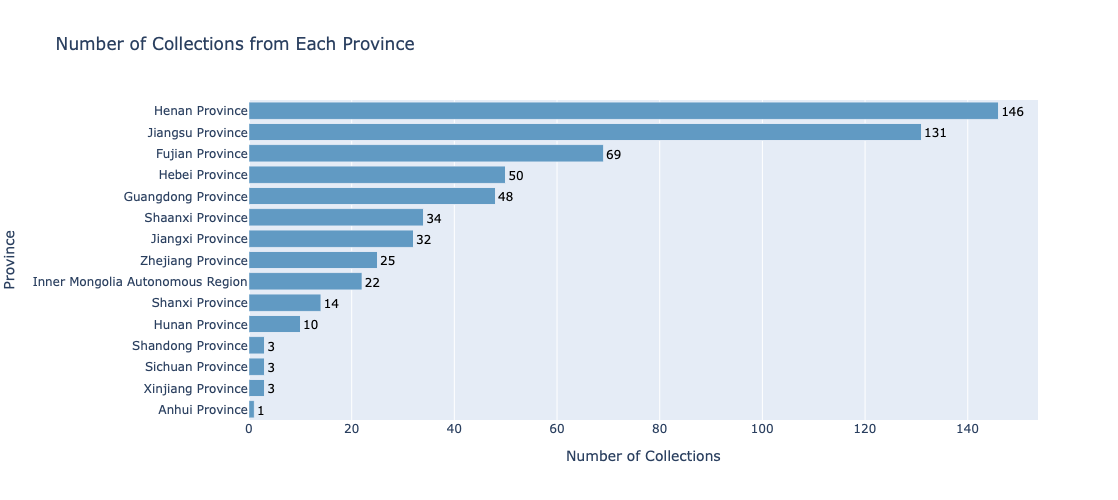

In [31]:
#对数量按降序排序
province_counts_sorted = province_counts.sort_values(ascending=False)

# 创建水平条形图
fig = go.Figure()

# 添加水平条形
fig.add_trace(go.Bar(
    y=province_counts_sorted.index[::-1],  # 反转排序后的索引，使条形图按从大到小顺序显示
    x=province_counts_sorted.values[::-1],  # 反转排序后的值
    orientation='h',
    marker=dict(color='#619AC3'),
    text=province_counts_sorted.values[::-1],  # 显示数量并反转顺序
    textposition='outside',
    textfont=dict(color='black')
))

# 设置图表布局
fig.update_layout(
    title='Number of Collections from Each Province',
    xaxis_title='Number of Collections',
    yaxis_title='Province',
    height=500  # 设置图表高度为 500 像素
)

# 显示图表
fig.show()

/var/folders/2q/4pt3l1310hsdw3s3474_y5p80000gn/T/ipykernel_4331/2944180952.py:10: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.

/opt/anaconda3/lib/python3.11/site-packages/matplotlib/text.py:753: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/opt/anaconda3/lib/python3.11/site-packages/matplotlib/text.py:754: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/opt/anaconda3/lib/python3.11/site-packages/matplotlib/text.py:894: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/opt/anaconda3/lib/python3.11/site-packages/matplotlib/te

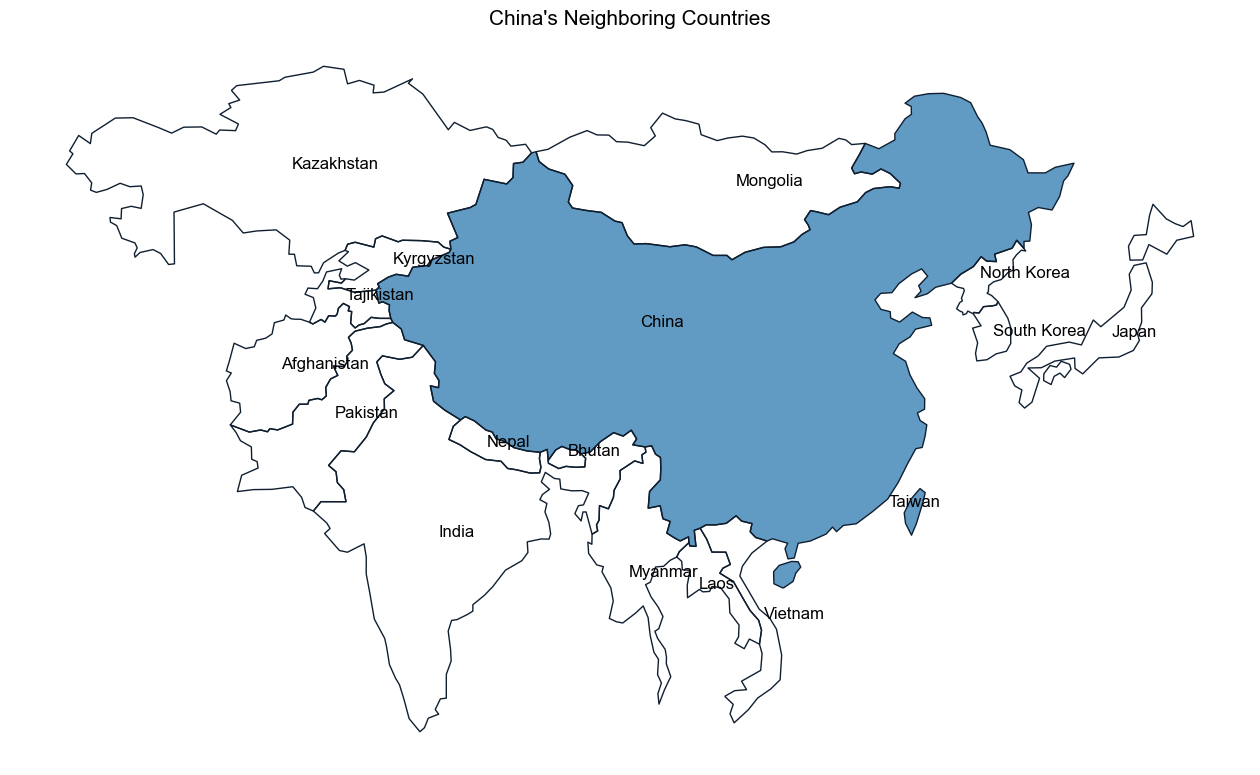

In [32]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import MultiPolygon, Polygon
import pandas as pd

# Set default font to Times New Roman
plt.rcParams['font.family'] = 'Arial,sans-serif'

# Load the world shapefile
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Define East Asian countries, excluding Taiwan since it will be merged with China
east_asia_countries = ['China', 'Japan', 'South Korea', 'North Korea', 'Mongolia', 'Nepal', 'India', 'Bhutan',
                       'Pakistan', 'Afghanistan', 'Kazakhstan', 'Kyrgyzstan', 'Tajikistan', 'Myanmar', 'Laos',
                       'Vietnam']

# Filter for East Asian countries
east_asia = world[world['name'].isin(east_asia_countries)]

# Get Taiwan's geometry
taiwan = world[world['name'] == 'Taiwan']

# Merge China and Taiwan geometries
mainland_china = east_asia[east_asia['name'] == 'China']
mainland_china_with_taiwan = pd.concat([mainland_china, taiwan])

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(16, 16))

# Plot all countries in black and white
east_asia.boundary.plot(ax=ax, linewidth=1, color='#101F30')

# Plot Taiwan's boundary in black
taiwan.boundary.plot(ax=ax, linewidth=1, color='#101F30')

# Fill China (including Taiwan) with #619AC3 color
mainland_china_with_taiwan.plot(ax=ax, color='#619AC3')

# Add label for China
x, y = mainland_china.geometry.representative_point().x, mainland_china.geometry.representative_point().y
ax.text(x, y, 'China', fontsize=12, ha='center')

# Add label for Taiwan
x, y = taiwan.geometry.representative_point().x, taiwan.geometry.representative_point().y
ax.text(x, y, 'Taiwan', fontsize=12, ha='center')

# Add country labels outside the map
for name, geom in zip(east_asia['name'], east_asia['geometry']):
    if name not in ['China', 'Taiwan']:
        if isinstance(geom, (Polygon, MultiPolygon)):
            x, y = geom.representative_point().x, geom.representative_point().y
            plt.text(x, y, name, fontsize=12)

# Set the title and remove axis
ax.set_title("China's Neighboring Countries", fontsize=15)
ax.set_axis_off()

plt.show()


### 3.5 Analysis of Freer’s Four Visits to China

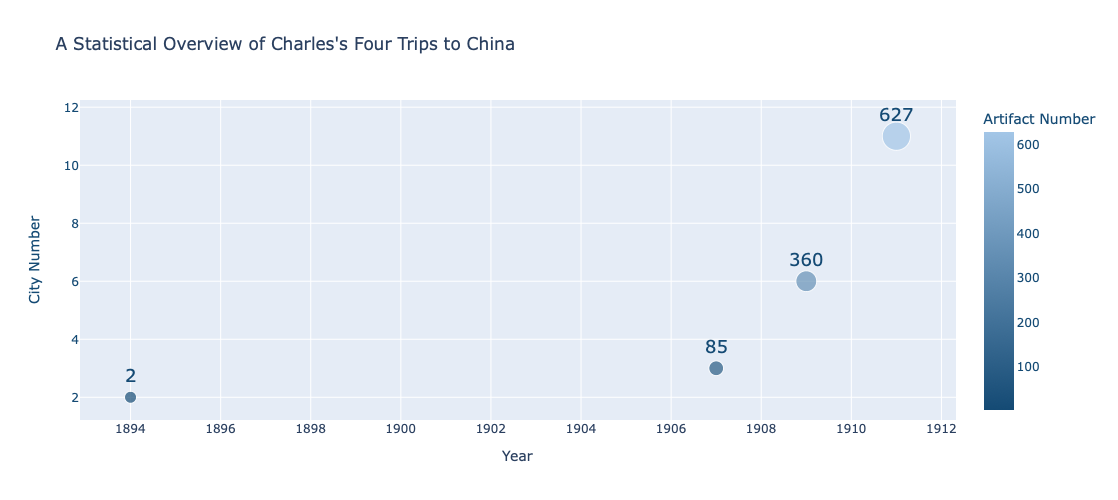

In [35]:
import plotly.express as px


data = {
    "Year": [1894, 1907, 1909, 1911],
    "Cities Visited": [2, 3, 6, 11],
    "Artifacts Collected": [2, 85, 360, 627]
}

# 使用 Plotly Express 创建散点图，根据数量来着色
fig = px.scatter(data, x="Year", y="Cities Visited", size="Cities Visited", color="Artifacts Collected", 
                 color_continuous_scale=["#144A74","#A3C6E7"], title="A Statistical Overview of Charles's Four Trips to China",
                 labels={"Cities Visited": "Cities Visited", "Year": "Year", "Artifacts Collected": "Artifacts Collected"},
                 hover_name="Year", hover_data={"Cities Visited": True, "Artifacts Collected": True})

# 设置布局
fig.update_layout(
    yaxis=dict(
        title='City Number',
        titlefont=dict(color='#144A74'),  # 左轴标题的颜色
        tickfont=dict(color='#144A74')  # 左刻度的颜色
    ),
    coloraxis_colorbar=dict(
        title='Artifact Number',  # 右轴标题
        titlefont=dict(color='#144A74'),  # 右标题的颜色
        tickfont=dict(color='#144A74'),  # 右刻度的颜色
    ),
    height = 500
)

# 在每个圆圈上标明对应的数字
for i, txt in enumerate(data["Artifacts Collected"]):
    fig.add_annotation(x=data["Year"][i], y=data["Cities Visited"][i]+0.8, text=str(txt), showarrow=False, font=dict(color='#144A74', size=18))

fig.show()


In [36]:
# first trip

import folium

# 缩小到中国
m = folium.Map(location=[35, 105], zoom_start=4)

# 添加轨迹线和标记，表示不同年份的行程和收藏文物数量
# 第一年的行程轨迹线 香港 上海
folium.PolyLine(locations=[[22.27, 114.16], [31.23, 121.47]], color='#2983BB', weight=2, opacity=1, popup='1990').add_to(m)
folium.CircleMarker(location=[22.27, 114.16], radius=5, color='#2983BB', fill=True, fill_color='#2983BB', fill_opacity=0.7, popup='1990: 2 artifacts').add_to(m)
folium.CircleMarker(location=[31.23, 121.47], radius=5, color='#2983BB', fill=True, fill_color='#2983BB', fill_opacity=0.7).add_to(m)

# 数量标记
folium.Marker([25, 118], icon=folium.DivIcon(icon_size=(150,36), icon_anchor=(0,0))).add_to(m)

m

In [37]:
# second trip

import folium

# 缩小到中国
m = folium.Map(location=[35, 105], zoom_start=4)

# 添加轨迹线和标记，表示不同年份的行程和收藏文物数量
# 第二年的行程轨迹线 香港 广州 上海
folium.PolyLine(locations=[[22.27, 114.16], [23.13, 113.27], [31.23, 121.47]], color='#2983BB', weight=2, opacity=1, popup='1995').add_to(m)
folium.CircleMarker(location=[22.27, 114.16], radius=5, color='#2983BB', fill=True, fill_color='#2983BB', fill_opacity=0.7, popup='1995: 85 artifacts').add_to(m)
folium.CircleMarker(location=[23.13, 113.27], radius=5, color='#2983BB', fill=True, fill_color='#2983BB', fill_opacity=0.7).add_to(m)
folium.CircleMarker(location=[31.23, 121.47], radius=5, color='#2983BB', fill=True, fill_color='#2983BB', fill_opacity=0.7).add_to(m)

# 数量
folium.Marker([25, 118], icon=folium.DivIcon(icon_size=(150,36), icon_anchor=(0,0))).add_to(m)

m

In [38]:
# third trip

import folium

# 缩小到中国
m = folium.Map(location=[35, 105], zoom_start=4)

# 定义城市坐标和标注信息
cities = [
    {"location": [22.27, 114.16], "name": "Hong Kong", "artifacts": "360 artifacts"},
    {"location": [31.23, 121.47], "name": "Shanghai"},
    {"location": [39.13, 117.20], "name": "Tianjin"},
    {"location": [39.90, 116.40], "name": "Beijing"},
    {"location": [30.59, 114.30], "name": "Hankou"},
    {"location": [31.23, 121.47], "name": "Shanghai"}
]

# 轨迹线
locations = [city["location"] for city in cities]
folium.PolyLine(locations=locations, color='#2983BB', weight=2, opacity=1, popup='1998').add_to(m)

# 圆形标记和弹出窗口
for city in cities:
    folium.CircleMarker(location=city["location"], radius=5, color='#2983BB', fill=True, fill_color='#2983BB', fill_opacity=0.7, popup=f'1998: {city.get("artifacts", "")}').add_to(m)

m


In [39]:
# fourth trip

import folium

# 缩小范围到中国
m = folium.Map(location=[35, 105], zoom_start=4)

# 定义城市坐标和标注
cities = [
    {"location": [31.23, 121.47], "name": "Shanghai"},
    {"location": [39.13, 117.20], "name": "Tianjin"},
    {"location": [36.10, 114.35], "name": "Anyang"},
    {"location": [34.80, 114.30], "name": "Kaifeng"},
    {"location": [34.68, 112.45], "name": "Luoyang"},
    {"location": [39.90, 116.40], "name": "Beijing"},
    {"location": [41.80, 123.45], "name": "Shenyang"},
    {"location": [38.80, 121.27], "name": "Lvshun"},
    {"location": [38.92, 121.65], "name": "Dalian"},
    {"location": [30.27, 120.15], "name": "Hangzhou"}
]

# 轨迹线
locations = [city["location"] for city in cities]
folium.PolyLine(locations=locations, color='#2983BB', weight=2, opacity=1, popup='1998').add_to(m)

# 圆形标记和弹出窗口
for city in cities:
    folium.CircleMarker(location=city["location"], radius=5, color='#2983BB', fill=True, fill_color='#2983BB', fill_opacity=0.7, popup=f'1998: {city.get("artifacts", "")}').add_to(m)

m
